# Regression Model

In [54]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV

import pickle


In [55]:
# Import dataframe
df0 = pickle.load(open('../../Data/Processed/regression_data.p','rb'))
df0.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [56]:
# Remove non desired data from model (Non predictor data or ethics concern)
df1 = df0.drop(['customer_id','gender'], axis=1)

In [57]:
# Shuffle data
df2 = shuffle(df1, random_state=42)

In [58]:
# Deal with missing values
df2.isna().sum()

distance_from_store       2
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [59]:
# Low value count for missing data so we drop
df3 = df2.dropna()

In [60]:
df3.head()

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,0.67,0.297,1904.55,376,36,3,52.904167


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'distance_from_store'),
  Text(1, 0, 'credit_score'),
  Text(2, 0, 'customer_loyalty_score'),
  Text(3, 0, 'transaction_count'),
  Text(4, 0, 'product_area_count'),
  Text(5, 0, 'average_basket_value')])

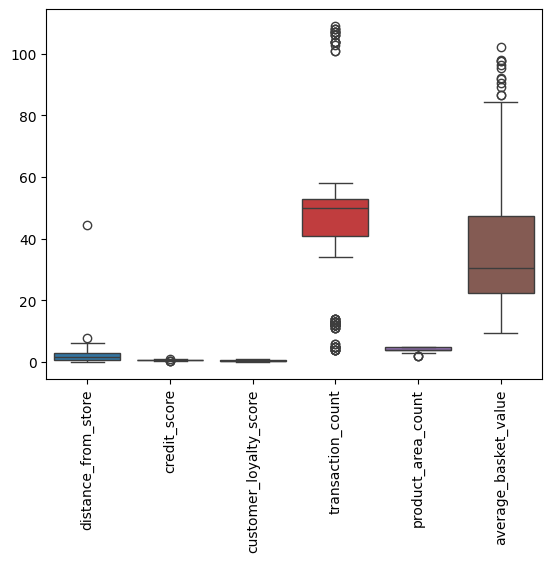

In [61]:
# Check for outliers
sns.boxplot(df3.drop(['total_sales','total_items'], axis=1))
plt.xticks(rotation=90)

([0, 1], [Text(0, 0, 'total_sales'), Text(1, 0, 'total_items')])

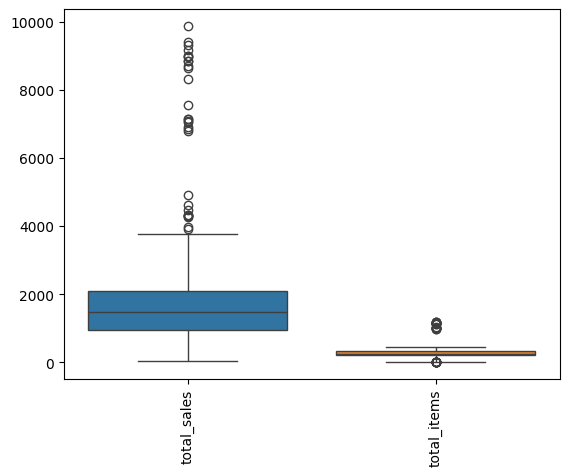

In [62]:
# Check for outliers
sns.boxplot(df3[['total_sales','total_items']])
plt.xticks(rotation=90)

In [63]:
df3.describe()

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,2.027778,0.595960,0.508369,1846.525177,277.906566,44.863636,4.313131,36.827691
std,2.563269,0.101345,0.294262,1766.486399,213.958990,21.253303,0.724214,19.348378
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.262000,941.555000,201.000000,40.750000,4.000000,22.411599
50%,1.655000,0.590000,0.509500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.912500,0.660000,0.770500,2109.292500,319.000000,53.000000,5.000000,47.300978
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


Distance_from_store, total_sales ans total_items all seem to have values clearly separated from the pack that could skew the model where as other dimensions seem more spread out over the range. The model might benefit from their removal.

In [64]:
# Outlier removal

outlier_columns = ['distance_from_store','total_sales','total_items']

for column in outlier_columns:
    
    lower_quartile = df3[column].quantile(0.25)
    upper_quartile = df3[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    min_border = lower_quartile - 2*iqr
    max_border = upper_quartile + 2*iqr
    
    outliers = df3[(df3[column] < min_border) | (df3[column] > max_border)].index
    print(f'{len(outliers)} outliers detected in column {column}')
    
    df3.drop(outliers, inplace = True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


C:\Users\max05\AppData\Local\Temp\ipykernel_22648\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace = True)
C:\Users\max05\AppData\Local\Temp\ipykernel_22648\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace = True)
C:\Users\max05\AppData\Local\Temp\ipykernel_22648\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace 

In [66]:
# Split into input 'X' and output 'y'
X = df3.drop(['customer_loyalty_score'], axis = 1)
y = df3['customer_loyalty_score']

In [67]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

Optimal number of features: 7


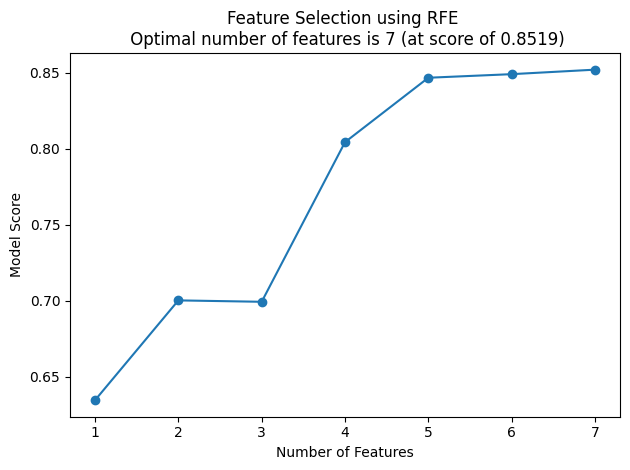

In [ ]:
# feature selection with regressive feature elemination
regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f'Optimal number of features: {optimal_feature_count}')

X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# Show results on a graph
plt.plot(range(1, len(fit.cv_results_['mean_test_score'])+1),
         fit.cv_results_['mean_test_score'],
         marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Model Score')
plt.title(f'Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})')
plt.tight_layout()
plt.show()


In [71]:
# Build model
regressor = LinearRegression()

In [72]:
# fit model
regressor.fit(X_train, y_train)

LinearRegression()

In [74]:
# Assess accuracy and R2
y_pred = regressor.predict(X_test) # Create predictions for tests
r_squared = r2_score(y_test,y_pred) # Compare prediction results to actual result
r_squared

0.8063471365818943

In [78]:
# Cross - validation
cv = KFold(n_splits = 4, shuffle=True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring='r2')
print(f'Cross-validation score : {round(cv_scores.mean(),2)}')

Cross-validation score : 0.86


In [80]:
# Calculate adjusted R2
num_data_points, num_input_vars = X_test.shape

adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R2 score : {round(adjusted_r_squared,2)}')

Adjusted R2 score : 0.79


In [97]:
coefficients = pd.DataFrame(regressor.coef_)
input_variable_names = pd.DataFrame(X_train.columns)
summary_stats = pd.concat([input_variable_names,coefficients], axis = 1)
summary_stats.columns = ['input_variable','coefficient']
summary_stats.sort_values(by=['coefficient'],ascending=False,inplace=True)

<Axes: xlabel='coefficient', ylabel='input_variable'>

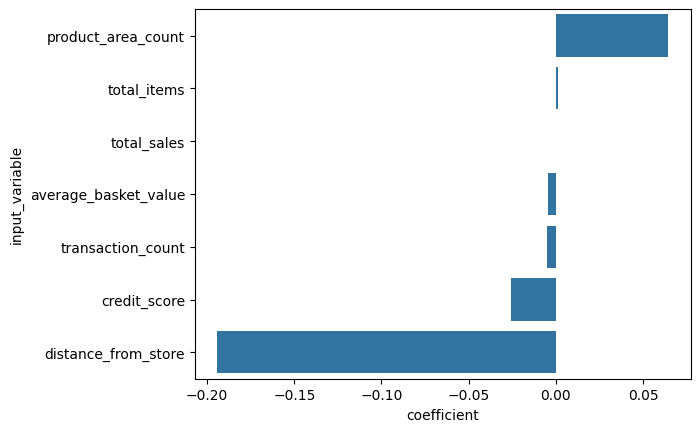

In [98]:
sns.barplot(summary_stats, x='coefficient', y='input_variable')